# Setup Environment

In [1]:
#Import the necessary Python modules
import os
import sys
sys.path.insert(0,'..')

# !pip install folium
import folium
import folium.plugins as plugins
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMap
from folium import IFrame, Map, Marker, GeoJson, LayerControl


print(folium.__file__)
print(folium.__version__)

import pandas as pd
import numpy as np
import random
from random import randint
import pickle

import re

# !pip install colormap

import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# from colormap import rgb2hex

import base64
from io import BytesIO

#! conda install -c anaconda networkx
import networkx as nx

#! conda install -c anaconda seaborn 
import seaborn as sns
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)});

from matplotlib.lines import Line2D
from IPython.display import IFrame

# !pip install json2html
import json
from json2html import *

# !pip install pyproj
import pyproj

import branca
import math

#from elevation import *
get_ipython().run_line_magic('matplotlib', 'inline')

/Users/ducvu/anaconda3/envs/map-gen/lib/python3.6/site-packages/folium/__init__.py
0.6.0


# Define function to read from pickle file of OpenDss test cases

In [2]:
############################################################
def read_pickle(data_pickle):
    with open(data_pickle, 'rb') as f:
        datadict = pickle.load(f)
    return datadict


############################################################
def import_dss_data(data_pickle):
    obj = read_pickle(data_pickle)
    AllBusNames = obj[0]
    AllLoadNames = obj[1]
    AllLineNames = obj[2]
    AllTransNames = obj[3]
    AllCapacitorNames = obj[4]
    AllTransNames = obj[5]
    AllSubNames = obj[6]
    Circuit = obj[7]

    return AllBusNames , AllLoadNames, AllLineNames, AllTransNames,  AllCapacitorNames, AllTransNames, AllSubNames, Circuit


############################################################
def generate_network_data(data_pickle):

    AllBusNames , AllLoadNames, AllLineNames, AllTransNames,  AllCapacitorNames, AllTransNames, AllSubNames, Circuit = import_dss_data(data_pickle)
    listBusKeys = list(AllBusNames.keys())
    listBusKeys = [i for i in listBusKeys if i is i != 'AllBusNames' and i != 'BusNumbers' and i!= 'NumBuses']
    listBuses = []
    for i in listBusKeys:
        if AllBusNames[i]['Coorddefined'] == True:
            listBuses.append(AllBusNames[i])


    listSubKeys = list(AllSubNames.keys())
    listSubKeys = [i for i in listSubKeys if i is i != 'AllSubNames' and i != 'SubNumbers' and i!= 'NumSubs']
    listSubs = []
    for i in listSubKeys:
        #if AllSubNames[i]['Coorddefined'] == True:
        if (AllSubNames[i].get('Coorddefined', "False") == True) or (AllSubNames[i].get('Coorddefined', "False") == 1):
            listSubs.append(AllSubNames[i])


    listLineKeys = list(AllLineNames.keys())
    listLineKeys = [i for i in listLineKeys if i is i != 'AllLineNames' and i != 'LineNumbers' and i!= 'NumLines']
    listLines = []
    for i in listLineKeys[3:]:
        listLines.append((AllLineNames[i]['Bus1'], AllLineNames[i]['Bus2']))


    listHighLines = []
    listLowLines = []

    listLowBuses = []
    listHighBuses = []

    voltageList = []
    for i in listBuses:

        kV_List = ['kVBase', 'kV_LN']

        if kV_List[0] in i.keys():
            voltageList.append(i[kV_List[0]])
        elif kV_List[1] in i.keys():
            voltageList.append(i[kV_List[1]])
    
    voltageList = list(set(voltageList))

    if len(voltageList) == 2:

        for i in listBuses:
            kV_List = ['kVBase', 'kV_LN']

            if kV_List[0] in i.keys():
                if i[kV_List[0]]*np.sqrt(3) == 34.5:
                    listHighBuses.append(i)
                elif i[kV_List[0]]*np.sqrt(3) == 13.2:
                    listLowBuses.append(i)

            elif kV_List[1] in i.keys():
                if i[kV_List[1]]*np.sqrt(3) == 4.16:
                    listHighBuses.append(i)
                elif i[kV_List[1]]*np.sqrt(3) == 0.48:
                    listLowBuses.append(i)

   
        lowBusNames = []
        highBusNames = []

        lowBusNames = [i['Name'] for i in listLowBuses]
        lowBusNames = list(set(lowBusNames))

        highBusNames = [i['Name'] for i in listHighBuses]
        highBusNames = list(set(highBusNames))

        listHighLines = [i for i in listLines if ((i[0] in highBusNames) &  (i[1] in highBusNames))]
        listLowLines = [i for i in listLines if ((i[0] in lowBusNames) &  (i[1] in lowBusNames))]

    return listBuses, listHighBuses, listLowBuses, listSubs, listLines, listHighLines, listLowLines, voltageList

############################################################
def extract_networks(data_pickle):
    data_name = data_pickle.split(os.sep)
    data_name = data_name[-1]

    listBuses, listHighBuses, listLowBuses, listSubs, listLines, listHighLines, listLowLines, voltageList = generate_network_data(data_pickle)
    
    bus_nodes = []
    high_bus_nodes = []
    low_bus_nodes = []
    sub_nodes = []
    edge_list = []
    high_edge_list = []
    low_edge_list = []
    
    nodes = {}
    edges = []
    
    if (not listHighBuses) and (not listLowBuses) and (not listHighLines) and (not listLowLines): 
        bus_nodes = [listBuses[i]['Name'] for i in range(len(listBuses))]
        bus_x_coord = [listBuses[i]['Coord_X'] for i in range(len(listBuses))]
        bus_y_coord = [listBuses[i]['Coord_Y'] for i in range(len(listBuses))]
        
        sub_nodes = [listSubs[i]['Name'] for i in range(len(listSubs))]
        sub_x_coord = [listSubs[i]['Coord_X'] for i in range(len(listSubs))]
        sub_y_coord = [listSubs[i]['Coord_Y'] for i in range(len(listSubs))]

        #nodes = {}
        for n in listBuses:
            nodes.update({n['Name']: (n['Coord_X'], n['Coord_Y'])})

        for n in listSubs:
            nodes.update({n['Name']: (n['Coord_X'], n['Coord_Y'])})

        edge_list = listLines
        edges.extend(edge_list)
        

    else:
        high_bus_nodes = [listHighBuses[i]['Name'] for i in range(len(listHighBuses))]
        low_bus_nodes  = [listLowBuses[i]['Name'] for i in range(len(listLowBuses))]
        sub_nodes = [listSubs[i]['Name'] for i in range(len(listSubs))]

        #nodes = {}
        for n in listHighBuses:
            nodes.update({n['Name']: (n['Coord_X'], n['Coord_Y'])})
    
        for n in listLowBuses:
            nodes.update({n['Name']: (n['Coord_X'], n['Coord_Y'])})
    
        for n in listSubs:
            nodes.update({n['Name']: (n['Coord_X'], n['Coord_Y'])})

        high_edge_list = listHighLines
        low_edge_list = listLowLines
        
        edges.extend(high_edge_list)
        edges.extend(low_edge_list)
        
    edges = [i for i in edges if i[0]  in nodes and i[1] in nodes ]    
    
    return bus_nodes, high_bus_nodes, low_bus_nodes, sub_nodes, edge_list, high_edge_list, low_edge_list, nodes, edges


############################################################
def generate_dataframe(data_pickle, coord, scale_x, scale_y):
    
    bus_nodes, high_bus_nodes, low_bus_nodes, sub_nodes, edge_list, high_edge_list, low_edge_list, nodes, edges  = extract_networks(data_pickle)
    
    # generate dataframe for nodes
    scaler = lambda xy_coord: scale_xy(xy_coord, scale_x, scale_y)
    
    location_list = list(map(scaler, list(nodes.values()) ))

    lats, lons = conv_xy_to_latlon(location_list, coord)

    df_node = pd.DataFrame(
        {'Node': list(nodes.keys()),
         'lat': lats,
         'lon': lons
        })


    centroid_coord = [ df_node['lat'].mean(), df_node['lon'].mean() ]
    
    # generate dataframe for edges
    df_line = pd.DataFrame(
    {'Node A': list(map(list, zip(*edges)))[0],
     'Node B': list(map(list, zip(*edges)))[1]
    })
    
    df_line = find_geometry_points(df_node, df_line)

    return df_node, df_line, centroid_coord

# Define lon-lat coordinates change

In [3]:
############################################################
def conv_xy_to_latlon(xy_list, origin_lat_lon):
    # lat_1=40.666667, lat_2=41.033333,
    origin_lat, origin_lon = origin_lat_lon
    lats, lons = [], []
    
    for x, y in xy_list:
        pnyc = pyproj.Proj( proj='tmerc', datum='NAD83', 
                           lat1=41.7557, lat2=41.6860,
                           lat_0=origin_lat, lon_0=origin_lon, 
                           x_0=0, y_0=0.0)
    
        lon, lat = pnyc(x, y, inverse=True)
        #print(lat, lon)
        lats.append(lat)
        lons.append(lon) 
        
    return lats, lons


############################################################
def find_geometry_points(df_node, df_edge):
    #node_label_dict = dict([(node,(lat, lon)) for node, lat, lon in zip(df_node['Node'], df_node['lat'],df_node['lon'])])
    node_label_dict = {x[0]: x[1:] for x in df_node.itertuples(index=False)}

    node_a = [node_label_dict[i] for i in df_edge['Node A'].tolist()]
    node_b = [node_label_dict[i] for i in df_edge['Node B'].tolist()]
    node_ab = list(zip(node_a,node_b))
    df_edge['Node_A_coord'] = node_a
    df_edge['Node_B_coord'] = node_b
    df_edge['Node_AB_coord'] = node_ab
    return df_edge



############################################################
def scale_xy(xy_coord, scale_x, scale_y):
    return ( xy_coord[0]%scale_x, xy_coord[1]%scale_y )  

'''
############################################################
def scale_xy(xy_coord, scale_x, scale_y):
    
    return ( xy_coord[0]*scale_x, xy_coord[1]*scale_y)  
'''


############################################################
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# https://andrew.hedges.name/experiments/haversine/
from math import sin, cos, sqrt, atan2, radians


############################################################
def spherical_distance(origin, destination):
    # approximate radius of earth in km
    R = 6373.0

    lat1, lon1 = origin
    lat2, lon2 = destination
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    print("The distance between ({}, {}) and ({}, {}): {} km".format(lat1, lon1, lat2, lon2, distance))
    return  distance


'''
def spherical_distance(origin, destination):
    
    lat1, lon1 = origin
    lat2, lon2 = destination
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    
    phi1 = 0.5*np.pi - lat1
    phi2 = 0.5*np.pi - lat2
    r = 0.5*(6378137 + 6356752) # mean radius in meters
    t = sin(phi1)*sin(phi2)*cos(lon1-lon2) + cos(phi1)*cos(phi2)
    distance = r * acos(t)
    print("The distance between ({}, {}) and ({}, {}): {} km".format(lat1, lon1, lat2, lon2, distance))
    return distance 
    
'''

############################################################
def generate_probabilty(n):
    mu, sigma = 0, 0.1 # mean and standard deviation
    #return np.random.normal(mu, sigma, n)
    return [ random.random() for i in range(n) ]


############################################################
def generate_discrete_probability(n):
    #random.sample(range(0, n), 2) 
    return [random.randrange(0, 2, 1) for _ in range(n)]


############################################################
# !pip install geopy
import geopy
from geopy.distance import VincentyDistance

def calculate_new_latlon_geopy(lat1, lon1):
    # given: lat1, lon1, b = bearing in degrees, d = distance in kilometers
    b = 2*np.pi
    d = 68

    origin = geopy.Point(lat1, lon1)
    destination = VincentyDistance(kilometers=d).destination(origin, b)

    lat2, lon2 = destination.latitude, destination.longitude  
    return lat2, lon2


############################################################
def offset_latlon(df_node, df_line):
    
    new_location = lambda x: calculate_new_latlon_geopy(x[0], x[1])

    location_list = list(map(new_location, list(zip(df_node['lat'], df_node['lon']))))

    df_node_new = pd.DataFrame(location_list, columns=['lat', 'lon'])
    df_node_new['Node'] = df_node['Node']
    
    # reorder columns
    df_node_new = df_node_new[['Node', 'lat', 'lon']]
    
    df_line_new = df_line.drop(['Node_A_coord', 'Node_B_coord', 'Node_AB_coord'], 1)
    df_line_new = find_geometry_points(df_node_new, df_line_new)  
    return df_node_new, df_line_new

# Folium visualization functions

In [4]:
############################################################
def df_to_html(row, info_name = None):
    
    #style = '<style> #myDIV { width: 360px;height: 50px;background-color: #FF7006;color: white;text-align:center;font-family:courier;font-size:10px;} </style> <div id="myDIV"> <h1>' + str(info_name) + '</h1> </div>' 
    style = '<style> #myDIV { width: 360px;height: 50px;background-color: #99bbff;color: white;text-align:center;font-family:courier;font-size:10px;} </style> <div id="myDIV"> <h1>' + str(info_name) + '</h1> </div>' 
    newdf = pd.DataFrame(row).copy(deep=True)

    html = newdf.to_html()
    html = html.replace('\n', ' ')
    html = html.replace('<table border="1" class="dataframe">','<table class="table table-striped">')
    html =  style + html


    #remove content between <thead>  </thead>
    pattern = r'.*?\<thead>(.*)\</thead>.*'
    match = re.search(pattern, html)
    header = match.group(1)
    html = html.replace(header,'')


    #replace <tr> with <tr style="text-align: left;">
    html = html.replace('<tr>','<tr style="text-align: left;">')
    return html


############################################################
def generate_baseMap(default_location=[40.5397293,-74.6273494], default_zoom_start=12, default_tile='openstreetmap'):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start, tiles=default_tile)
    return base_map





In [5]:
############################################################
from folium import IFrame

##Create folium polyline layer
#make folium polyline for each edge in df_edge
def generate_folium_polyline(edge, attr, edge_width, edge_opacity=0.15, info_name = None):

    locations = [(coord[0], coord[1]) for coord in edge['Node_AB_coord']]
    
    #edge color
    edge_color = '#339FFF'
    #edge_color = '#00FF7F' # green color
    #edge_color = '8A837B' # brown color
    #edge_color = 'EFFA07'
    
    row = edge[attr]
    html = df_to_html(row, info_name = info_name)
    iframe = IFrame(html=html, width=360, height=240)
    popup = folium.Popup(iframe, max_width=2650)
    
    
    # create a folium polyline with attributes
    #pl = folium.PolyLine(locations=locations, popup=popup, color=edge_color, weight=edge_width, opacity=edge_opacity)
    pl = folium.PolyLine(locations=locations, color=edge_color, weight=edge_width, opacity=edge_opacity)
    return pl



############################################################
#create folium polyline layer
def add_polyline(mapobj, df, attr = [], layer_name = None,  info_name = None):

    
    #polyline_layer = folium.FeatureGroup(name = str(layer_name), overlay=False)
    polyline_layer = folium.FeatureGroup(name = str(layer_name))
    
    for _, row in df.iterrows():
        #pl = generate_folium_polyline(row, attr, edge_width=row['probability'], edge_opacity=3, prob_name=prob_name, info_name = info_name)
        pl = generate_folium_polyline(row, attr, edge_width=5, edge_opacity=3, info_name = info_name)
        pl.add_to(polyline_layer)

    polyline_layer.add_to(mapobj)
    
    return mapobj







                                                                                                                           
############################################################
#create heatmap data layer
def generate_heat_data(df_line, heatmap_attr = None):
    n = len(df_line)
  
    center_point = [(np.mean([pair_node[0][0], pair_node[1][0]]), 
                     np.mean([pair_node[0][1], pair_node[1][1]]) ) for pair_node in df_line['Node_AB_coord'].tolist()]
    
    df_heat_map = pd.DataFrame(center_point, columns=['lat', 'lon'])
    df_heat_map = pd.concat([df_heat_map, df_line], axis=1)
    df_heat_map.rename(columns={'Node A': 'Start Node', 'Node B': 'End Node'}, inplace=True)
    
    if  heatmap_attr == 'Failure Probability':
        df_heat_map['probability'] = df_line['Failure Probability']
    if heatmap_attr == 'Damage Status':
        df_heat_map['probability'] = df_line['Damage Status'].apply(lambda x : 1 if x =='Damaged' else 0)

    #heat_data = df_new.as_matrix()
    heat_data = df_heat_map[['lat', 'lon', 'probability']].values.tolist()
    return heat_data,  df_heat_map




############################################################
#create heatmap layer
def add_heatmap(mapobj, df_line, attr=[], radius=20, heat_name=None, info_name=None, colors=None, caption=None, colormap=None, heatmap_attr=None):

    heatmap_layer = folium.FeatureGroup(name = str(heat_name))
    
    heat_data, df_heat_map = generate_heat_data(df_line, heatmap_attr)
    

    vmin   = np.min(df_heat_map['probability'])
    vmax   = np.max(df_heat_map['probability'])
    cm     = branca.colormap.LinearColormap(colors, vmin=vmin, vmax=vmax, caption = caption)
   
    tooltip = '<i>Click here</i>'


         
    for _, row in df_heat_map.iterrows(): 
        row = row[attr]
    
        html = df_to_html(row[[x for x in attr if x not in set(['lat', 'lon'])]], info_name = info_name)
        iframe = IFrame(html=html, width=360, height=200)
        popup = folium.Popup(iframe, max_width=2650)
        
        #fill_color='#FFFFFF',
        folium.Circle(np.array([row['lat'], row['lon'] ]), 
                      radius=10,
                      popup=popup,
                      fill=True, 
                      opacity = 0.005, 
                      stroke = False,
                      tooltip = tooltip,
                      color = '#FFFFFF').add_to(heatmap_layer)
        heatmap_layer.add_to(mapobj)   
    
    HeatMap(heat_data, 
            name = heat_name, 
            radius = radius, 
            gradient = colormap, 
            min_opacity=0.2,
            max_val=float(df_heat_map['probability'].max()),
            blur=15,
            max_zoom=1).add_to(folium.FeatureGroup(name = str(heat_name)).add_to(mapobj))
           
    mapobj.add_child(cm)
         
    
    return mapobj




####################################################################################
#create point cluster layer
def add_point_clusters(mapobj, df_node, attr = [], node_icon = None, node_name = None, icon_size=(15, 15), info_name = None):
    

    #point_layer = folium.FeatureGroup(name = node_name, overlay=False)
    point_layer = folium.FeatureGroup(name = node_name)

    for _, row in df_node.iterrows(): 
        
        row = row[attr]
         
        html = df_to_html(row[[x for x in attr if x not in set(['lat', 'lon'])]], info_name = info_name)
        iframe = IFrame(html=html, width=360, height=200)
        popup = folium.Popup(iframe, max_width=2650)
        
        if row['Damage Status'] == 'Substation Intact':
            icon_url = 'https://raw.githubusercontent.com/dvu4/grid_folium/master/data/r_diamond.png'
            icon = folium.features.CustomIcon(icon_url, icon_size=icon_size) #(30, 30)
            
            # extract lat and long coordinates to assign to the marker
            folium.Marker(np.array([row['lat'], row['lon']]), popup=popup, icon=icon).add_to(point_layer)
        else :
            icon_url = 'https://raw.githubusercontent.com/dvu4/grid_folium/master/data/g-diamond.png'
            icon = folium.features.CustomIcon(icon_url, icon_size=icon_size)
            
            # extract lat and long coordinates to assign to the marker
            folium.Marker(np.array([row['lat'], row['lon']]), popup=popup, icon=icon).add_to(point_layer)
        
    
        #FastMarkerCluster(np.array([row.lat, row.lon]), popup=popup, icon=icon).add_to(point_layer)
    #Create a Folium feature group for this layer, since we will be displaying multiple layers
    point_layer.add_to(mapobj)
    
    
    legend_html =   '''
                 <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 110px; height: 75px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            "><br>
                              &nbsp; Substation &nbsp; <img src='https://raw.githubusercontent.com/dvu4/grid_folium/master/data/r_diamond.png'
                              alt="Smiley face" width="18" height="18" align="right"><br>
                              &nbsp; PV   &nbsp; <img src='https://raw.githubusercontent.com/dvu4/grid_folium/master/data/g-diamond.png'
                              alt="Smiley face" width="18" height="18" align="right">
                 </div>
                                       
                ''' 

    mapobj.get_root().html.add_child(folium.Element(legend_html))
    
    return mapobj

# Weather Metric_Flood

In [6]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import geojsoncontour
import scipy as sp
import scipy.ndimage

def generate_legend_property(geojson):
    unique_titles = []
    for i in geojson['features']:
        n = round(float(i['properties']['title']), 2)
        unique_titles.append(n)
        unique_titles = sorted(list(set(unique_titles)), reverse=True)

    properties_dict = {str(i): str(x) for i,x in enumerate(unique_titles)}
    return properties_dict

####################################################################################
#create GeoJSON and TopoJSON layers 
def generate_contour(mapobj, centroid_coord, nb_class = 10, contour_name = None, df_flood = None):
    
    # Setup colormap
    #colors = ['#d7191c',  '#fdae61',  '#ffffbf',  '#abdda4',  '#2b83ba']
    #levels = len(colors)
    #cm     = branca.colormap.LinearColormap(colors, vmin=0, vmax=1).to_step(levels)
    #cm     = branca.colormap.LinearColormap(['b','c','g','y','r'], vmin=0, vmax=1)
    cm     = branca.colormap.LinearColormap(['#0000FF', '#6495ED', '#00FFFF', '#008000', '#8FBC8F', '#FFFF00', '#FFA500', '#FFA07A', '#FF6347', '#FF0000'], 
                                            vmin=1, 
                                            vmax=10, 
                                            caption = contour_name)  
    xl = pd.ExcelFile("./data/Flood_weather_metric.xlsx")
    df_flood = xl.parse("Sheet1")
    
    if df_flood is not None:

        # The original data
        x_orig = np.asarray(df_flood['longitude  (x coordinates)'].tolist())
        y_orig = np.asarray(df_flood['latitude (y coordinates)'].tolist())
        z_orig = np.asarray(df_flood['Flood Depth (ft)'].tolist())
     
    
        x_arr = df_flood.iloc[:,1]
        y_arr = df_flood.iloc[:,2]
        z_arr = df_flood.iloc[:,0]
    
    
        grid_x, grid_y = np.mgrid[-88.5231:-88.3651:801j, 41.6859:41.8039:601j]
    
        points = np.transpose(np.vstack((x_arr,y_arr)))
        values = z_arr
    
        grid_z0 = griddata(points, values, (grid_x, grid_y), method='cubic')
        grid_z0 = grid_z0 + 0.5
        
        
        x_mesh = grid_x
        y_mesh = grid_y
        z_mesh = grid_z0
        contourf = plt.contourf(x_mesh,y_mesh, z_mesh, nb_class, alpha=0.5, cmap=plt.cm.jet)


    
    else:
        # Create a dataframe with fake data
        df = pd.DataFrame({
            'longitude':   np.random.normal(centroid_coord[1],    0.075,     10000),
            'latitude':    np.random.normal(centroid_coord[0],    0.075,     10000),
            'probability': [random.randint(1,10) for i in range(10000)]
            #'probability': np.random.normal(0, 1, 10000)})
        })
            

        # The original data
        x_orig = np.asarray(df.longitude.tolist())
        y_orig = np.asarray(df.latitude.tolist())
        z_orig = np.asarray(df.probability.tolist())
 
        # Make a grid
        x_arr          = np.linspace(np.min(x_orig), np.max(x_orig), 1000)
        y_arr          = np.linspace(np.min(y_orig), np.max(y_orig), 1000)
        x_mesh, y_mesh = np.meshgrid(x_arr, y_arr)
 
        wave = 0.75*(np.sin(2.*y_mesh)**8*np.cos(4.*x_mesh))
        mean = 0.5*np.cos(2.*y_mesh)*((np.sin(2.*y_mesh))**2 + 2.)
        z_mesh = wave + mean
     
        
    # Create the contour
    #contourf = plt.contourf(x_mesh, y_mesh, z_mesh, levels, alpha=0.5, colors=colors)
    contourf = plt.contourf(x_mesh, y_mesh, z_mesh, nb_class, alpha=0.5, cmap=plt.cm.jet)
 
    # Convert matplotlib contourf to geojson
    geojson = geojsoncontour.contourf_to_geojson(
        contourf=contourf,
        min_angle_deg=3.0,
        ndigits=5,
        stroke_width=1,
        fill_opacity=0.5)

    
    # Plot the contour plot on folium
    folium.GeoJson(
            geojson,
            name = contour_name,
            style_function=lambda x: {
                'color':     x['properties']['stroke'],
                'weight':    x['properties']['stroke-width'],
                'fillColor': x['properties']['fill'],
                'opacity':   0.6}).add_to(mapobj)    
    
    # Add the colormap to the folium map
    mapobj.add_child(cm) 
    
    return mapobj

# Define plot function

In [7]:
from folium import IFrame

def plot_grid(data_pickle, default_coord, df_node, df_line, df_flood, df_flood_substation_pv_node):

    name = data_pickle.split('/')[-1].split('.')[0]
    centroid_coord = [ df_node['lat'].mean(), df_node['lon'].mean() ]
    
    folium_map = generate_baseMap(default_location=centroid_coord)

    #Update basemap with GeoJSON Layer
    folium_map = generate_contour(folium_map, 
                                 centroid_coord, 
                                 contour_name = 'Flood Depth',
                                 df_flood = df_flood)
    

    
    #Update basemap with Polyline Layer
    folium_map = add_polyline(folium_map, 
                             df_line, 
                             attr = ['Node A', 'Node B'],
                             layer_name = 'Grid',
                             info_name = 'Line Information')


    
    #Update basemap with point cluster layer
    folium_map = add_point_clusters(folium_map, 
                                   df_flood_substation_pv_node, 
                                   attr = ['Node', 'Flood Depth', 'Failure Probability', 'Damage Status', 'lat', 'lon'],  
                                   node_name = 'Substation & PV Panel',
                                   icon_size=(24, 24),
                                   info_name = 'Details of Electric Component')
    
    #Update basemap with heatmap Layer   
    colors = ['b','c','g','y','r']
    caption = 'Failure Probability'
    colormap = {0.0: 'blue', 0.3:'coral', 0.5: 'green', 0.7: 'yellow', 1.0: 'red'}
    heatmap_attr = 'Failure Probability'

    folium_map = add_heatmap(folium_map, 
                 df_line, 
                 attr=['lat', 'lon', 'Start Node', 'End Node', 'Length', 'Flood Depth', 'Failure Probability', 'Damage Status'], 
                 radius=20, 
                 heat_name=caption , 
                 info_name='Details of Electric Component' , 
                 colors=colors, 
                 caption=caption, 
                 colormap=colormap, 
                 heatmap_attr=heatmap_attr)

    
    
    # Damage Status
    colors_ds = ['black','orange','r']
    caption_ds = 'Damage Status'
    colormap_ds = {0.0: '#000000', 0.5: '#8b0000', 1.0: '#d80000'}
    heatmap_attr_ds = 'Damage Status'

    folium_map = add_heatmap(folium_map, 
                 df_line, 
                 attr=['lat', 'lon', 'Start Node', 'End Node', 'Length', 'Flood Depth', 'Failure Probability', 'Damage Status'], 
                 radius=20, 
                 heat_name=caption_ds, 
                 info_name='Details of Electric Component', 
                 colors=colors_ds, 
                 caption=caption_ds, 
                 colormap=colormap_ds, 
                 heatmap_attr=heatmap_attr_ds)    
    
    
    
    folium.TileLayer('stamentoner').add_to(folium_map)
    folium.TileLayer('stamenwatercolor').add_to(folium_map)
    folium.TileLayer('Stamen Terrain').add_to(folium_map)
    folium.TileLayer('cartodbdark_matter').add_to(folium_map)
    folium.TileLayer('cartodbpositron').add_to(folium_map)
    
    
    # Fullscreen
    plugins.Fullscreen(position='topright',
                       title='Expand me',
                       title_cancel='Exit me',
                       force_separate_button=True).add_to(folium_map)


    folium_map.add_child(folium.LayerControl(collapsed=True)) #Add layer control to toggle on/off
    
    
    filepath = os.getcwd() + '/' + name + '.html'    
    folium_map.save(filepath)
    
    IFrame(filepath, width=600, height=500) #display map

# System input: 128500 system

In [8]:
###
data_name = 'data/test_system_data/ckt12_ieee8500_system_data.dat'
data_path = os.getcwd() + '/'
data_pickle = data_path + data_name

##################################################################################
_, _, _, _, _, _, _, nodes, edges  = extract_networks(data_pickle)
df_node_offset = pd.DataFrame.from_dict(nodes, orient='index')
df_node_offset.reset_index(level=0, inplace=True)
df_node_offset.rename(columns={'index': 'Node', 0: 'lon',  1: 'lat'}, inplace=True)

df_node_offset['lon'] = df_node_offset['lon'].apply(lambda i: i/364647.0 -88.4700)
df_node_offset['lat'] = df_node_offset['lat'].apply(lambda i: i/364647.0 +41.7470)
df_node_offset = df_node_offset[['Node','lat','lon']]
df_node_offset.head()
#[X,Y]/364647 +[-88.4700, 41.7470]


##################################################################################
default_coord = [41.7470, -88.4700]
scale_x = 1
scale_y = 1
    
df_node, df_line, centroid_coord = generate_dataframe(data_pickle, default_coord, scale_x, scale_y)

df_line.drop(['Node_A_coord', 'Node_B_coord', 'Node_AB_coord'], axis=1, inplace=True)
df_line = find_geometry_points(df_node_offset, df_line)
df_node = df_node_offset
df_line.head()

,Node A,Node B,Node_A_coord,Node_B_coord,Node_AB_coord
0,157345,157346,"(41.743181238293474, -88.46848483601948)","(41.74300983965314, -88.46845741223704)","((41.743181238293474, -88.46848483601948), (41..."
1,165442,298160,"(41.74238594860235, -88.4681283268476)","(41.73753193910823, -88.46903331166854)","((41.74238594860235, -88.4681283268476), (41.7..."
2,165448,275354,"(41.73277391285271, -88.46896475221241)","(41.72581512805535, -88.46797749604411)","((41.73277391285271, -88.46896475221241), (41...."
3,165449,165450,"(41.72525294051508, -88.46802548766341)","(41.72477988026777, -88.46873850600718)","((41.72525294051508, -88.46802548766341), (41...."
4,165453,165454,"(41.72355266600301, -88.46888933681066)","(41.72362122545914, -88.46941038867726)","((41.72355266600301, -88.46888933681066), (41...."


# 128500 Flood

In [9]:
### flood weather metric
xl = pd.ExcelFile("./data/Flood_weather_metric.xlsx")
print(xl.sheet_names)
df_flood = xl.parse("Sheet1")
df_flood.head()

### flood damage
xl = pd.ExcelFile("./data/Flood_damge_128500.xlsx")
print(xl.sheet_names)


# ### 1. Wrangling line
df_flood_line = xl.parse("Line")
rm_quote = lambda x: x.replace("\'", "")
#df_flood_line['Start node'] = df_flood_line['Start node'].apply(lambda s: s.replace("\'" ,""))
df_flood_line['Start node'] = df_flood_line['Start node'].apply(rm_quote)
df_flood_line['End node'] = df_flood_line['End node'].apply(rm_quote)
df_flood_line['Damage Status'] = df_flood_line['Damage Status'].apply(rm_quote)
print(list(df_flood_line.columns.values))
df_flood_line.rename(columns={'Start node': 'Node A', 'End node': 'Node B'}, inplace=True)
df_flood_line.head()


# In[9]:


df_flood_line = find_geometry_points(df_node, df_flood_line)
df_flood_line.head()


# In[10]:


discrete_probability = lambda x : 1 if x =='Damaged' else 0
a = df_flood_line['Damage Status'].apply(discrete_probability)
print(len([i for i in a if i == 0]))
print(len([i for i in a if i == 1]))
list(df_flood_line.columns.values)


# In[11]:


print(len(df_flood_line))
print(len(df_flood_line[df_flood_line['Damage Status'] == 'Intact']['Damage Status'] ))
print(len(df_flood_line[df_flood_line['Damage Status'] == 'Damaged']['Damage Status'] ))



df_flood_substation_node = xl.parse("Substation")
rm_quote = lambda x: x.replace("\'", "")
df_flood_substation_node['Damage Status'] = df_flood_substation_node['Damage Status'].apply(rm_quote)
df_flood_substation_node['node'] = df_flood_substation_node['node'].astype(str)
df_flood_substation_node.rename(columns={'node': 'Node'}, inplace=True)
df_flood_substation_node = df_flood_substation_node.merge(df_node, how='left', on='Node') 


df_flood_pv_node = xl.parse("PV Panel")
rm_quote = lambda x: x.replace("\'", "")
df_flood_pv_node['Damage Status'] = df_flood_pv_node['Damage Status'].apply(rm_quote)
df_flood_pv_node['node'] = df_flood_pv_node['node'].apply(rm_quote)
df_flood_pv_node['node'] = df_flood_pv_node['node'].astype(str)
df_flood_pv_node.rename(columns={'node': 'Node'}, inplace=True)
df_flood_pv_node = df_flood_pv_node.merge(df_node, how='left', on='Node') 

#df_node = df_node.merge(df_flood_pv_node, how='left', left_on='Node', right_on='node')
df_flood_substation_pv_node = df_flood_pv_node.append(df_flood_substation_node, ignore_index=True)
#df_flood_substation_pv_node

['Sheet1']
['Line', 'Substation', 'PV Panel', 'Summary']
['Start node', 'End node', 'Length', 'Flood Depth', 'Failure Probability', 'Damage Status']
3534
139
3673
3534
139


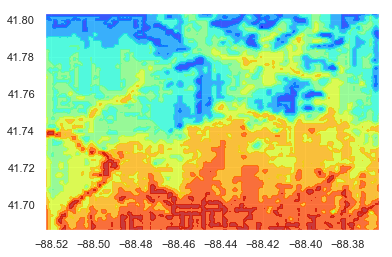

In [10]:
plot_grid(data_pickle, default_coord, df_node, df_flood_line, df_flood, df_flood_substation_pv_node)

# System input: 123 system

In [23]:
data_name = 'data/test_system_data/IEEE123_system_data.dat'
data_path = os.getcwd() + '/'
data_pickle = data_path + data_name

##################################################################################
_, _, _, _, _, _, _, nodes, edges  = extract_networks(data_pickle)
df_node_offset = pd.DataFrame.from_dict(nodes, orient='index')
df_node_offset.reset_index(level=0, inplace=True)
df_node_offset.rename(columns={'index': 'Node', 0: 'lon',  1: 'lat'}, inplace=True)

df_node_offset['lon'] = df_node_offset['lon'].apply(lambda i: i*42/364647.0 -88.4441)
df_node_offset['lat'] = df_node_offset['lat'].apply(lambda i: i*42/364647.0 +41.7439)
df_node_offset = df_node_offset[['Node','lat','lon']]
df_node_offset.head()
#[X,Y]/364647 +[-88.4700, 41.7470]


##################################################################################
default_coord = [41.7439, -88.4441]
scale_x = 1
scale_y = 1
    
df_node, df_line, centroid_coord = generate_dataframe(data_pickle, default_coord, scale_x, scale_y)

df_line.drop(['Node_A_coord', 'Node_B_coord', 'Node_AB_coord'], axis=1, inplace=True)
df_line = find_geometry_points(df_node_offset, df_line)
df_node = df_node_offset
df_line.head()

,Node A,Node B,Node_A_coord,Node_B_coord,Node_AB_coord
0,3,4,"(41.7443607195452, -88.4424874815918)","(41.7441303597726, -88.4424874815918)","((41.7443607195452, -88.4424874815918), (41.74..."
1,3,5,"(41.7443607195452, -88.4424874815918)","(41.7443607195452, -88.44214194193289)","((41.7443607195452, -88.4424874815918), (41.74..."
2,5,6,"(41.7443607195452, -88.44214194193289)","(41.7443607195452, -88.44179640227398)","((41.7443607195452, -88.44214194193289), (41.7..."
3,7,8,"(41.74516697874931, -88.44214194193289)","(41.74528215863561, -88.44179640227398)","((41.74516697874931, -88.44214194193289), (41...."
4,8,12,"(41.74528215863561, -88.44179640227398)","(41.7449366189767, -88.44196917210344)","((41.74528215863561, -88.44179640227398), (41...."


# 123 flood

In [24]:
### flood weather metric
xl = pd.ExcelFile("./data/Flood_weather_metric.xlsx")
print(xl.sheet_names)
df_flood = xl.parse("Sheet1")
df_flood.head()

### flood damage
xl = pd.ExcelFile("./data/Flood_damge_123.xlsx")
print(xl.sheet_names)


# ### 1. Wrangling line
df_flood_line = xl.parse("Line")
rm_quote = lambda x: x.replace("\'", "")
#df_flood_line['Start node'] = df_flood_line['Start node'].apply(lambda s: s.replace("\'" ,""))
df_flood_line['Start node'] = df_flood_line['Start node'].astype(str)
df_flood_line['End node'] = df_flood_line['End node'].astype(str)
df_flood_line['Damage Status'] = df_flood_line['Damage Status'].apply(rm_quote)
print(list(df_flood_line.columns.values))
df_flood_line.rename(columns={'Start node': 'Node A', 'End node': 'Node B'}, inplace=True)
df_flood_line.head()


# In[9]:


df_flood_line = find_geometry_points(df_node, df_flood_line)
df_flood_line.head()


# In[10]:


discrete_probability = lambda x : 1 if x =='Damaged' else 0
a = df_flood_line['Damage Status'].apply(discrete_probability)
print(len([i for i in a if i == 0]))
print(len([i for i in a if i == 1]))
list(df_flood_line.columns.values)


# In[11]:


print(len(df_flood_line))
print(len(df_flood_line[df_flood_line['Damage Status'] == 'Intact']['Damage Status'] ))
print(len(df_flood_line[df_flood_line['Damage Status'] == 'Damaged']['Damage Status'] ))



df_flood_substation_node = xl.parse("Substation")
rm_quote = lambda x: x.replace("\'", "")
df_flood_substation_node['Damage Status'] = df_flood_substation_node['Damage Status'].apply(rm_quote)
df_flood_substation_node['node'] = df_flood_substation_node['node'].astype(str)
df_flood_substation_node.rename(columns={'node': 'Node'}, inplace=True)
df_flood_substation_node = df_flood_substation_node.merge(df_node, how='left', on='Node') 


df_flood_pv_node = xl.parse("PV Panel")
rm_quote = lambda x: x.replace("\'", "")
df_flood_pv_node['Damage Status'] = df_flood_pv_node['Damage Status'].apply(rm_quote)
#  df_flood_pv_node['node'] = df_flood_pv_node['node'].apply(rm_quote)
df_flood_pv_node['node'] = df_flood_pv_node['node'].astype(str)
df_flood_pv_node.rename(columns={'node': 'Node'}, inplace=True)
df_flood_pv_node = df_flood_pv_node.merge(df_node, how='left', on='Node') 

#df_node = df_node.merge(df_flood_pv_node, how='left', left_on='Node', right_on='node')
df_flood_substation_pv_node = df_flood_pv_node.append(df_flood_substation_node, ignore_index=True)
#df_flood_substation_pv_node

['Sheet1']
['Line', 'Substation', 'PV Panel', 'Summary ']
['Start node', 'End node', 'Length', 'Flood Depth', 'Failure Probability', 'Damage Status']
113
5
118
113
5


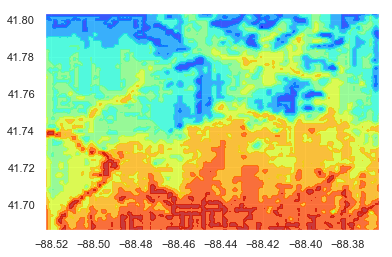

In [25]:
plot_grid(data_pickle, default_coord, df_node, df_flood_line, df_flood, df_flood_substation_pv_node)